In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
import argparse
import pickle as pkl
import time
from copy import deepcopy

from tqdm import tqdm
import torch.optim.lr_scheduler as lr_scheduler
import os
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from random import shuffle
from torch import nn
from torchvision.models import resnet50, ResNet50_Weights
import torch.nn.functional as F
from torchvision.transforms import v2
torch.manual_seed(19)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datapoints\__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback

In [2]:
transforms = v2.Compose([
    # v2.RandomResizedCrop(size=(224, 224), antialias=True),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPerspective(0.4),
    v2.ToDtype(torch.float32)
])


class NMINSTImageDataset(Dataset):
    def __init__(self, img_dir_file, transform=None, target_transform=None):
        self.images1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_x_resolution.npy').astype(np.float32)
        self.labels1 = np.load(img_dir_file + 'train_MNIST_Voxel1_trilinear_y_resolution.npy')
        self.images2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_x_resolution.npy').astype(np.float32)
        self.labels2 = np.load(img_dir_file + 'train_MNIST_Voxel2_trilinear_y_resolution.npy')
        self.images3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_x_resolution.npy').astype(np.float32)
        self.labels3 = np.load(img_dir_file + 'train_MNIST_Voxel3_trilinear_y_resolution.npy')

        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels1) + len(self.labels2) + len(self.labels3)

    def __getitem__(self, idx):
        if idx//10000 == 0:
            image = self.images1[idx%10000]
            label = self.labels1[idx%10000]
        elif idx//10000 == 1:
            image = self.images2[idx%10000]
            label = self.labels2[idx%10000]
        elif idx//10000 == 2:
            image = self.images3[idx%10000]
            label = self.labels3[idx%10000]

        label_temp = np.zeros((10,))
        label_temp[label] = 1
        if self.stage == 0:
            return self.transform(torch.tensor(image)), torch.tensor(label_temp)
        else:
            return torch.tensor(image), torch.tensor(label_temp)
        
    def set_stage(self, stage):
        self.stage = stage

In [3]:
from torch.utils.data import DataLoader
data = NMINSTImageDataset("Datasety/", transform=transforms)
generator1 = torch.Generator().manual_seed(42)
test_data, training_data = torch.utils.data.random_split(data, [0.3, 0.7], generator=generator1)

del data

In [4]:
train_dataloader = DataLoader(training_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=True)

In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None, end_maxpool = False):
        super(ResidualBlock, self).__init__()
        if(downsample is not None):
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.ReLU(inplace=False),
                            nn.MaxPool2d(kernel_size=2, stride=2)
                            )  # Changed inplace to False
        else:
            self.conv1 = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding='same'),
                            nn.BatchNorm2d(out_channels),
                            nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)
                            )
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1),
                        nn.BatchNorm2d(out_channels),
                        nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False))  # Changed inplace to False
        self.downsample = downsample
        self.relu = nn.Hardtanh(min_val=-1.0, max_val=1.0, inplace=False)  # Changed inplace to False
        self.out_channels = out_channels
        self.end_maxpool = end_maxpool

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out = out + residual
        if self.end_maxpool:
            out = F.relu(out, inplace=False)
        else:
            out = F.hardtanh(out, inplace=False, min_val=-1.0, max_val=1.0)   # Use non-in-place ReLU
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 2, in_chanels = 10):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_chanels, 64, kernel_size = 7, stride = 1, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU(inplace=False))
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2, end_maxpool = True)
        self.avgpool = nn.MaxPool2d(7, stride=1)
        self.fc = nn.Linear(2048, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, blocks, stride=1, end_maxpool = False):
        downsample = None
        if stride != 1 or self.inplanes != planes:

            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=1, padding='same'),
                nn.BatchNorm2d(planes),
                nn.ReLU(inplace=False),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            if i == blocks-1 and end_maxpool:
                layers.append(block(self.inplanes, planes, end_maxpool = True))
            else:
                layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = F.hardtanh(x)
        x = self.fc2(x)
        return x
    
    def train_model(self, train_loader, valid_loader, num_epochs = 5, learning_rate=0.001, save_best = False, save_thr = 0.94):
        best_accuracy = 0.0
        total_step = len(train_loader)
        train_accuracy_h = []
        test_accuracy_h = []
        train_loss_h = []
        test_loss_h = []
        # Loss and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.RMSprop(self.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)  
        scheduler = lr_scheduler.ExponentialLR(optimizer, gamma=0.9)#LinearLR(optimizer,  start_factor=start_factor, end_factor=end_factor, total_iters=total_iters)
        for epoch in range(num_epochs):
            # self.train()
            correct = 0
            total = 0
            running_loss = 0.0
            train_loader.dataset.dataset.set_stage(0)
            for i, (images, labels) in enumerate(tqdm(train_loader)):
                # Move tensors to the configured device
                images = images.float().to("cuda")
                labels = labels.type(torch.FloatTensor)
                labels = labels.to("cuda")


                optimizer.zero_grad()

                # Forward pass
                outputs = self.forward(images)
                loss = criterion(outputs, labels)
                # Backward and optimize
                loss.backward()
                
                optimizer.step()

                # accuracy
                _, predicted = torch.max(outputs.data, 1)
                correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                total += labels.size(0)
                running_loss += loss.item()
                del images, labels, outputs
            train_accuracy_h.append((float(correct))/total)
            train_loss_h.append(running_loss/len(train_loader))
            print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.4f}'
                            .format(epoch+1, num_epochs, i+1, total_step, running_loss/len(train_loader), (float(correct))/total))

            scheduler.step()
            if torch.cuda.is_available():
                torch.cuda.empty_cache()

            # Validation
            with torch.no_grad():
                correct = 0
                total = 0
                val_loss = 0.0
                valid_loader.dataset.dataset.set_stage(1)
                for images, labels in valid_loader:
                    images = images.float().to("cuda")
                    labels = labels.type(torch.FloatTensor)
                    labels = labels.to("cuda")
                    outputs = self.forward(images)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (torch.eq(predicted, torch.max(labels,1)[1])).sum().item()
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    del images, labels, outputs
                if(((100 * correct / total) > best_accuracy) and save_best and ((100 * correct / total) > save_thr)):
                    torch.save(self.state_dict(), "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool__128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")
                test_accuracy_h.append((float(correct))/total)
                test_loss_h.append(val_loss/len(valid_loader))
                print('Accuracy of the network: {} Loss: {}'.format( correct / total, val_loss/len(valid_loader)))
        return train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h

In [6]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
model_resnet = ResNet(ResidualBlock, [3, 4, 6, 3], num_classes = 10, in_chanels=5).to("cuda")
print(model_resnet)

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kerne

### Copy weights

In [7]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet34', pretrained=True)

Using cache found in C:\Users\nikos/.cache\torch\hub\pytorch_vision_v0.10.0
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:

size_layer = [3, 4, 6, 3]
layers = [(model_resnet.layer0, model.layer1), (model_resnet.layer1, model.layer2), (model_resnet.layer2, model.layer3), (model_resnet.layer3, model.layer4)]
for n in range(len(layers)):
    for i in range(size_layer[n]):
        layers[n][0][i].conv1[0] = layers[n][1][i].conv1
        layers[n][0][i].conv1[0].stride = 1
        layers[n][0][i].conv2[0] = layers[n][1][i].conv2
        layers[n][0][i].conv2[0].stride = 1
        
        layers[n][0][i].conv1[1] = layers[n][1][i].bn1
        layers[n][0][i].conv2[1] = layers[n][1][i].bn2

model_resnet.layer1[0].downsample[0] = model.layer2[0].downsample[0]
model_resnet.layer1[0].downsample[0].stride = 1
model_resnet.layer1[0].downsample[1] = model.layer2[0].downsample[1]

model_resnet.layer2[0].downsample[0] = model.layer3[0].downsample[0]
model_resnet.layer2[0].downsample[0].stride = 1
model_resnet.layer2[0].downsample[1] = model.layer3[0].downsample[1]

model_resnet.layer3[0].downsample[0] = model.layer4[0].downsample[0]
model_resnet.layer3[0].downsample[0].stride = 1
model_resnet.layer3[0].downsample[1] = model.layer4[0].downsample[1]

model_resnet.to("cuda")

ResNet(
  (conv1): Sequential(
    (0): Conv2d(5, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): ResidualBlock(
      (conv1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (conv2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=1, padding=(1, 1), bias=False)
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): Hardtanh(min_val=-1.0, max_val=1.0)
      )
      (relu): Hardtanh(min_val=-1.0, max_val=1.0)
    )
    (1): ResidualBlock(
      (conv1): Sequential(
        (0): Conv

In [9]:
torch.autograd.set_detect_anomaly(True)
train_accuracy_h, test_accuracy_h, train_loss_h, test_loss_h = model_resnet.train_model(train_dataloader, test_dataloader,num_epochs=120,save_best=True, save_thr=90)

100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [1/120], Step [657/657], Loss: 2.8286, Accuracy: 0.1051
Accuracy of the network: 0.187 Loss: 2.598013218835736


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [2/120], Step [657/657], Loss: 2.0652, Accuracy: 0.2145
Accuracy of the network: 0.3224444444444444 Loss: 1.6795967724306364


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [3/120], Step [657/657], Loss: 1.5528, Accuracy: 0.3908
Accuracy of the network: 0.49677777777777776 Loss: 1.2726274380024443


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [4/120], Step [657/657], Loss: 1.0198, Accuracy: 0.6112
Accuracy of the network: 0.6428888888888888 Loss: 0.9381444340056562


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [5/120], Step [657/657], Loss: 0.8576, Accuracy: 0.6835
Accuracy of the network: 0.7654444444444445 Loss: 0.689055307008696


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [6/120], Step [657/657], Loss: 0.7750, Accuracy: 0.7222
Accuracy of the network: 0.7895555555555556 Loss: 0.6116028492543715


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [7/120], Step [657/657], Loss: 0.7134, Accuracy: 0.7440
Accuracy of the network: 0.7554444444444445 Loss: 0.6550034173625581


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [8/120], Step [657/657], Loss: 0.6202, Accuracy: 0.7852
Accuracy of the network: 0.7681111111111111 Loss: 0.6644478292329937


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [9/120], Step [657/657], Loss: 0.5676, Accuracy: 0.8103
Accuracy of the network: 0.8288888888888889 Loss: 0.5270693460677532


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [10/120], Step [657/657], Loss: 0.5137, Accuracy: 0.8294
Accuracy of the network: 0.856 Loss: 0.4692512075846077


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [11/120], Step [657/657], Loss: 0.4769, Accuracy: 0.8431
Accuracy of the network: 0.8818888888888889 Loss: 0.37842680149255914


100%|██████████| 657/657 [03:23<00:00,  3.22it/s]


Epoch [12/120], Step [657/657], Loss: 0.4450, Accuracy: 0.8542
Accuracy of the network: 0.8745555555555555 Loss: 0.4067712312049054


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [13/120], Step [657/657], Loss: 0.4262, Accuracy: 0.8647
Accuracy of the network: 0.872 Loss: 0.40004083815407243


100%|██████████| 657/657 [03:23<00:00,  3.22it/s]


Epoch [14/120], Step [657/657], Loss: 0.4060, Accuracy: 0.8678
Accuracy of the network: 0.9032222222222223 Loss: 0.3238780051205598


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [15/120], Step [657/657], Loss: 0.3840, Accuracy: 0.8757
Accuracy of the network: 0.9081111111111111 Loss: 0.3138242061679245


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [16/120], Step [657/657], Loss: 0.3593, Accuracy: 0.8870
Accuracy of the network: 0.9062222222222223 Loss: 0.30268536302003457


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [17/120], Step [657/657], Loss: 0.3456, Accuracy: 0.8905
Accuracy of the network: 0.91 Loss: 0.2996623195337911


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [18/120], Step [657/657], Loss: 0.3311, Accuracy: 0.8958
Accuracy of the network: 0.9082222222222223 Loss: 0.2995451678990895


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [19/120], Step [657/657], Loss: 0.3176, Accuracy: 0.8982
Accuracy of the network: 0.9122222222222223 Loss: 0.2772651422398944


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [20/120], Step [657/657], Loss: 0.3035, Accuracy: 0.9054
Accuracy of the network: 0.9242222222222222 Loss: 0.2590235454816345


100%|██████████| 657/657 [03:23<00:00,  3.22it/s]


Epoch [21/120], Step [657/657], Loss: 0.2932, Accuracy: 0.9103
Accuracy of the network: 0.9275555555555556 Loss: 0.24450607049602566


100%|██████████| 657/657 [03:23<00:00,  3.22it/s]


Epoch [22/120], Step [657/657], Loss: 0.2849, Accuracy: 0.9145
Accuracy of the network: 0.9373333333333334 Loss: 0.22408626184977115


100%|██████████| 657/657 [03:23<00:00,  3.22it/s]


Epoch [23/120], Step [657/657], Loss: 0.2744, Accuracy: 0.9160
Accuracy of the network: 0.9317777777777778 Loss: 0.2262243153197123


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [24/120], Step [657/657], Loss: 0.2606, Accuracy: 0.9225
Accuracy of the network: 0.9371111111111111 Loss: 0.21187603951874354


100%|██████████| 657/657 [02:54<00:00,  3.77it/s]


Epoch [25/120], Step [657/657], Loss: 0.2541, Accuracy: 0.9231
Accuracy of the network: 0.9288888888888889 Loss: 0.23431482870158152


100%|██████████| 657/657 [02:51<00:00,  3.84it/s]


Epoch [26/120], Step [657/657], Loss: 0.2424, Accuracy: 0.9267
Accuracy of the network: 0.9422222222222222 Loss: 0.20187405030513908


100%|██████████| 657/657 [03:12<00:00,  3.42it/s]


Epoch [27/120], Step [657/657], Loss: 0.2309, Accuracy: 0.9299
Accuracy of the network: 0.949 Loss: 0.18209172074570723


100%|██████████| 657/657 [02:46<00:00,  3.95it/s]


Epoch [28/120], Step [657/657], Loss: 0.2192, Accuracy: 0.9328
Accuracy of the network: 0.9416666666666667 Loss: 0.19619204424955744


100%|██████████| 657/657 [02:57<00:00,  3.70it/s]


Epoch [29/120], Step [657/657], Loss: 0.2116, Accuracy: 0.9377
Accuracy of the network: 0.9511111111111111 Loss: 0.1756232164483121


100%|██████████| 657/657 [02:42<00:00,  4.04it/s]


Epoch [30/120], Step [657/657], Loss: 0.2067, Accuracy: 0.9400
Accuracy of the network: 0.9446666666666667 Loss: 0.18330604904694547


100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [31/120], Step [657/657], Loss: 0.1972, Accuracy: 0.9427
Accuracy of the network: 0.9466666666666667 Loss: 0.18582413271597936


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [32/120], Step [657/657], Loss: 0.1935, Accuracy: 0.9430
Accuracy of the network: 0.9505555555555556 Loss: 0.17137782621785258


100%|██████████| 657/657 [03:28<00:00,  3.16it/s]


Epoch [33/120], Step [657/657], Loss: 0.1913, Accuracy: 0.9436
Accuracy of the network: 0.9524444444444444 Loss: 0.16550671404346506


100%|██████████| 657/657 [02:44<00:00,  3.98it/s]


Epoch [34/120], Step [657/657], Loss: 0.1841, Accuracy: 0.9451
Accuracy of the network: 0.9484444444444444 Loss: 0.17302338341713375


100%|██████████| 657/657 [03:12<00:00,  3.42it/s]


Epoch [35/120], Step [657/657], Loss: 0.1799, Accuracy: 0.9464
Accuracy of the network: 0.9542222222222222 Loss: 0.15862460511716756


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [36/120], Step [657/657], Loss: 0.1789, Accuracy: 0.9479
Accuracy of the network: 0.9548888888888889 Loss: 0.15365899048402165


100%|██████████| 657/657 [03:32<00:00,  3.10it/s]


Epoch [37/120], Step [657/657], Loss: 0.1706, Accuracy: 0.9507
Accuracy of the network: 0.9515555555555556 Loss: 0.156392197388865


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [38/120], Step [657/657], Loss: 0.1702, Accuracy: 0.9510
Accuracy of the network: 0.9577777777777777 Loss: 0.1478521181468634


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [39/120], Step [657/657], Loss: 0.1691, Accuracy: 0.9505
Accuracy of the network: 0.9563333333333334 Loss: 0.15011873149729155


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [40/120], Step [657/657], Loss: 0.1634, Accuracy: 0.9549
Accuracy of the network: 0.9575555555555556 Loss: 0.14420456811785698


100%|██████████| 657/657 [03:43<00:00,  2.95it/s]


Epoch [41/120], Step [657/657], Loss: 0.1633, Accuracy: 0.9533
Accuracy of the network: 0.9576666666666667 Loss: 0.14561760101916518


100%|██████████| 657/657 [03:38<00:00,  3.01it/s]


Epoch [42/120], Step [657/657], Loss: 0.1582, Accuracy: 0.9550
Accuracy of the network: 0.9601111111111111 Loss: 0.14206003282113489


100%|██████████| 657/657 [03:40<00:00,  2.98it/s]


Epoch [43/120], Step [657/657], Loss: 0.1560, Accuracy: 0.9554
Accuracy of the network: 0.9575555555555556 Loss: 0.14554727279600946


100%|██████████| 657/657 [03:35<00:00,  3.05it/s]


Epoch [44/120], Step [657/657], Loss: 0.1551, Accuracy: 0.9566
Accuracy of the network: 0.959 Loss: 0.14282174380694299


100%|██████████| 657/657 [03:37<00:00,  3.02it/s]


Epoch [45/120], Step [657/657], Loss: 0.1549, Accuracy: 0.9558
Accuracy of the network: 0.9596666666666667 Loss: 0.1417592042158787


100%|██████████| 657/657 [03:32<00:00,  3.09it/s]


Epoch [46/120], Step [657/657], Loss: 0.1514, Accuracy: 0.9572
Accuracy of the network: 0.9618888888888889 Loss: 0.13725897416815902


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [47/120], Step [657/657], Loss: 0.1501, Accuracy: 0.9592
Accuracy of the network: 0.9613333333333334 Loss: 0.1375122863455867


100%|██████████| 657/657 [03:12<00:00,  3.41it/s]


Epoch [48/120], Step [657/657], Loss: 0.1492, Accuracy: 0.9584
Accuracy of the network: 0.9607777777777777 Loss: 0.1389911229266448


100%|██████████| 657/657 [02:54<00:00,  3.76it/s]


Epoch [49/120], Step [657/657], Loss: 0.1497, Accuracy: 0.9574
Accuracy of the network: 0.9578888888888889 Loss: 0.14001906531076905


100%|██████████| 657/657 [03:12<00:00,  3.41it/s]


Epoch [50/120], Step [657/657], Loss: 0.1462, Accuracy: 0.9592
Accuracy of the network: 0.9615555555555556 Loss: 0.13405549794052404


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [51/120], Step [657/657], Loss: 0.1448, Accuracy: 0.9600
Accuracy of the network: 0.9631111111111111 Loss: 0.13649031241153572


100%|██████████| 657/657 [03:01<00:00,  3.63it/s]


Epoch [52/120], Step [657/657], Loss: 0.1427, Accuracy: 0.9600
Accuracy of the network: 0.9636666666666667 Loss: 0.13035699139937018


100%|██████████| 657/657 [02:43<00:00,  4.02it/s]


Epoch [53/120], Step [657/657], Loss: 0.1433, Accuracy: 0.9603
Accuracy of the network: 0.9615555555555556 Loss: 0.13500223807488562


100%|██████████| 657/657 [03:06<00:00,  3.52it/s]


Epoch [54/120], Step [657/657], Loss: 0.1411, Accuracy: 0.9610
Accuracy of the network: 0.9608888888888889 Loss: 0.13464047206261903


100%|██████████| 657/657 [03:20<00:00,  3.28it/s]


Epoch [55/120], Step [657/657], Loss: 0.1421, Accuracy: 0.9604
Accuracy of the network: 0.9624444444444444 Loss: 0.13476199850255083


100%|██████████| 657/657 [03:36<00:00,  3.04it/s]


Epoch [56/120], Step [657/657], Loss: 0.1399, Accuracy: 0.9609
Accuracy of the network: 0.9624444444444444 Loss: 0.13071962420214364


100%|██████████| 657/657 [03:14<00:00,  3.38it/s]


Epoch [57/120], Step [657/657], Loss: 0.1375, Accuracy: 0.9620
Accuracy of the network: 0.9635555555555556 Loss: 0.12911366430236726


100%|██████████| 657/657 [03:10<00:00,  3.45it/s]


Epoch [58/120], Step [657/657], Loss: 0.1379, Accuracy: 0.9617
Accuracy of the network: 0.9616666666666667 Loss: 0.1315181863210197


100%|██████████| 657/657 [02:54<00:00,  3.77it/s]


Epoch [59/120], Step [657/657], Loss: 0.1395, Accuracy: 0.9618
Accuracy of the network: 0.9624444444444444 Loss: 0.13063670747669032


100%|██████████| 657/657 [03:39<00:00,  3.00it/s]


Epoch [60/120], Step [657/657], Loss: 0.1345, Accuracy: 0.9633
Accuracy of the network: 0.9611111111111111 Loss: 0.1313318387664696


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [61/120], Step [657/657], Loss: 0.1381, Accuracy: 0.9615
Accuracy of the network: 0.9628888888888889 Loss: 0.12930115194766656


100%|██████████| 657/657 [03:38<00:00,  3.00it/s]


Epoch [62/120], Step [657/657], Loss: 0.1342, Accuracy: 0.9634
Accuracy of the network: 0.9616666666666667 Loss: 0.13168999431852965


100%|██████████| 657/657 [02:46<00:00,  3.94it/s]


Epoch [63/120], Step [657/657], Loss: 0.1355, Accuracy: 0.9623
Accuracy of the network: 0.964 Loss: 0.1256953513791375


100%|██████████| 657/657 [03:42<00:00,  2.95it/s]


Epoch [64/120], Step [657/657], Loss: 0.1374, Accuracy: 0.9618
Accuracy of the network: 0.9621111111111111 Loss: 0.12833270475479727


100%|██████████| 657/657 [03:20<00:00,  3.28it/s]


Epoch [65/120], Step [657/657], Loss: 0.1368, Accuracy: 0.9614
Accuracy of the network: 0.9628888888888889 Loss: 0.1257837690571521


100%|██████████| 657/657 [02:38<00:00,  4.15it/s]


Epoch [66/120], Step [657/657], Loss: 0.1354, Accuracy: 0.9630
Accuracy of the network: 0.9631111111111111 Loss: 0.12694602640649527


100%|██████████| 657/657 [02:55<00:00,  3.75it/s]


Epoch [67/120], Step [657/657], Loss: 0.1339, Accuracy: 0.9623
Accuracy of the network: 0.9632222222222222 Loss: 0.12766290516823742


100%|██████████| 657/657 [03:38<00:00,  3.01it/s]


Epoch [68/120], Step [657/657], Loss: 0.1332, Accuracy: 0.9620
Accuracy of the network: 0.9646666666666667 Loss: 0.12645548783203073


100%|██████████| 657/657 [03:44<00:00,  2.93it/s]


Epoch [69/120], Step [657/657], Loss: 0.1339, Accuracy: 0.9620
Accuracy of the network: 0.9626666666666667 Loss: 0.12753681366246009


100%|██████████| 657/657 [02:47<00:00,  3.93it/s]


Epoch [70/120], Step [657/657], Loss: 0.1306, Accuracy: 0.9636
Accuracy of the network: 0.9632222222222222 Loss: 0.12815151082232912


100%|██████████| 657/657 [02:58<00:00,  3.69it/s]


Epoch [71/120], Step [657/657], Loss: 0.1321, Accuracy: 0.9631
Accuracy of the network: 0.963 Loss: 0.12815671955096594


100%|██████████| 657/657 [03:30<00:00,  3.13it/s]


Epoch [72/120], Step [657/657], Loss: 0.1383, Accuracy: 0.9618
Accuracy of the network: 0.9641111111111111 Loss: 0.12563170330163012


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [73/120], Step [657/657], Loss: 0.1303, Accuracy: 0.9639
Accuracy of the network: 0.9645555555555556 Loss: 0.1256598421828227


100%|██████████| 657/657 [03:33<00:00,  3.08it/s]


Epoch [74/120], Step [657/657], Loss: 0.1319, Accuracy: 0.9635
Accuracy of the network: 0.964 Loss: 0.12762038107195223


100%|██████████| 657/657 [03:39<00:00,  3.00it/s]


Epoch [75/120], Step [657/657], Loss: 0.1319, Accuracy: 0.9638
Accuracy of the network: 0.9652222222222222 Loss: 0.12277060095881316


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [76/120], Step [657/657], Loss: 0.1303, Accuracy: 0.9646
Accuracy of the network: 0.9655555555555555 Loss: 0.1236004883172453


100%|██████████| 657/657 [03:27<00:00,  3.16it/s]


Epoch [77/120], Step [657/657], Loss: 0.1298, Accuracy: 0.9644
Accuracy of the network: 0.964 Loss: 0.1245047802581115


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [78/120], Step [657/657], Loss: 0.1305, Accuracy: 0.9643
Accuracy of the network: 0.9638888888888889 Loss: 0.12751079498004195


100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [79/120], Step [657/657], Loss: 0.1331, Accuracy: 0.9649
Accuracy of the network: 0.964 Loss: 0.12478077324794222


100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [80/120], Step [657/657], Loss: 0.1312, Accuracy: 0.9645
Accuracy of the network: 0.9635555555555556 Loss: 0.12606726477834138


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [81/120], Step [657/657], Loss: 0.1321, Accuracy: 0.9634
Accuracy of the network: 0.9648888888888889 Loss: 0.12439987424708215


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [82/120], Step [657/657], Loss: 0.1336, Accuracy: 0.9628
Accuracy of the network: 0.9636666666666667 Loss: 0.128086141138899


100%|██████████| 657/657 [03:29<00:00,  3.13it/s]


Epoch [83/120], Step [657/657], Loss: 0.1311, Accuracy: 0.9639
Accuracy of the network: 0.9626666666666667 Loss: 0.1279157365124065


100%|██████████| 657/657 [03:25<00:00,  3.20it/s]


Epoch [84/120], Step [657/657], Loss: 0.1305, Accuracy: 0.9630
Accuracy of the network: 0.9624444444444444 Loss: 0.1260341771297051


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [85/120], Step [657/657], Loss: 0.1341, Accuracy: 0.9618
Accuracy of the network: 0.9647777777777777 Loss: 0.12224859254870643


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [86/120], Step [657/657], Loss: 0.1302, Accuracy: 0.9642
Accuracy of the network: 0.9632222222222222 Loss: 0.1250650697645355


100%|██████████| 657/657 [02:45<00:00,  3.97it/s]


Epoch [87/120], Step [657/657], Loss: 0.1309, Accuracy: 0.9638
Accuracy of the network: 0.964 Loss: 0.1232343638540371


100%|██████████| 657/657 [02:42<00:00,  4.05it/s]


Epoch [88/120], Step [657/657], Loss: 0.1344, Accuracy: 0.9615
Accuracy of the network: 0.963 Loss: 0.12810763033727804


100%|██████████| 657/657 [02:59<00:00,  3.67it/s]


Epoch [89/120], Step [657/657], Loss: 0.1319, Accuracy: 0.9624
Accuracy of the network: 0.9626666666666667 Loss: 0.12900165940720773


100%|██████████| 657/657 [02:56<00:00,  3.72it/s]


Epoch [90/120], Step [657/657], Loss: 0.1328, Accuracy: 0.9624
Accuracy of the network: 0.9653333333333334 Loss: 0.12356218520604761


100%|██████████| 657/657 [02:48<00:00,  3.90it/s]


Epoch [91/120], Step [657/657], Loss: 0.1308, Accuracy: 0.9629
Accuracy of the network: 0.9622222222222222 Loss: 0.1247683635562764


100%|██████████| 657/657 [03:13<00:00,  3.40it/s]


Epoch [92/120], Step [657/657], Loss: 0.1313, Accuracy: 0.9636
Accuracy of the network: 0.9657777777777777 Loss: 0.12059204615256254


100%|██████████| 657/657 [02:44<00:00,  4.00it/s]


Epoch [93/120], Step [657/657], Loss: 0.1293, Accuracy: 0.9648
Accuracy of the network: 0.964 Loss: 0.1248907833591315


100%|██████████| 657/657 [02:48<00:00,  3.90it/s]


Epoch [94/120], Step [657/657], Loss: 0.1302, Accuracy: 0.9641
Accuracy of the network: 0.9642222222222222 Loss: 0.1246607213327331


100%|██████████| 657/657 [02:58<00:00,  3.68it/s]


Epoch [95/120], Step [657/657], Loss: 0.1340, Accuracy: 0.9630
Accuracy of the network: 0.9634444444444444 Loss: 0.1257476225785964


100%|██████████| 657/657 [02:53<00:00,  3.80it/s]


Epoch [96/120], Step [657/657], Loss: 0.1306, Accuracy: 0.9628
Accuracy of the network: 0.9643333333333334 Loss: 0.12478142137249522


100%|██████████| 657/657 [03:28<00:00,  3.14it/s]


Epoch [97/120], Step [657/657], Loss: 0.1330, Accuracy: 0.9626
Accuracy of the network: 0.9642222222222222 Loss: 0.12485610133578591


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [98/120], Step [657/657], Loss: 0.1317, Accuracy: 0.9630
Accuracy of the network: 0.964 Loss: 0.12310817563602476


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [99/120], Step [657/657], Loss: 0.1334, Accuracy: 0.9633
Accuracy of the network: 0.9646666666666667 Loss: 0.1253318787644888


100%|██████████| 657/657 [03:29<00:00,  3.14it/s]


Epoch [100/120], Step [657/657], Loss: 0.1350, Accuracy: 0.9613
Accuracy of the network: 0.9633333333333334 Loss: 0.1254747286438942


100%|██████████| 657/657 [03:31<00:00,  3.10it/s]


Epoch [101/120], Step [657/657], Loss: 0.1292, Accuracy: 0.9642
Accuracy of the network: 0.9636666666666667 Loss: 0.12721190823519485


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [102/120], Step [657/657], Loss: 0.1309, Accuracy: 0.9638
Accuracy of the network: 0.9633333333333334 Loss: 0.12559954977944388


100%|██████████| 657/657 [03:26<00:00,  3.18it/s]


Epoch [103/120], Step [657/657], Loss: 0.1342, Accuracy: 0.9605
Accuracy of the network: 0.9632222222222222 Loss: 0.12673396736726905


100%|██████████| 657/657 [03:23<00:00,  3.23it/s]


Epoch [104/120], Step [657/657], Loss: 0.1308, Accuracy: 0.9637
Accuracy of the network: 0.9622222222222222 Loss: 0.12584253267140677


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [105/120], Step [657/657], Loss: 0.1288, Accuracy: 0.9651
Accuracy of the network: 0.9648888888888889 Loss: 0.12528752919009073


100%|██████████| 657/657 [03:31<00:00,  3.11it/s]


Epoch [106/120], Step [657/657], Loss: 0.1341, Accuracy: 0.9618
Accuracy of the network: 0.9623333333333334 Loss: 0.12542295723440164


100%|██████████| 657/657 [03:27<00:00,  3.16it/s]


Epoch [107/120], Step [657/657], Loss: 0.1343, Accuracy: 0.9618
Accuracy of the network: 0.9626666666666667 Loss: 0.1259795161796377


100%|██████████| 657/657 [03:24<00:00,  3.21it/s]


Epoch [108/120], Step [657/657], Loss: 0.1282, Accuracy: 0.9647
Accuracy of the network: 0.9623333333333334 Loss: 0.1250767602373892


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [109/120], Step [657/657], Loss: 0.1296, Accuracy: 0.9624
Accuracy of the network: 0.9644444444444444 Loss: 0.12610546766998285


100%|██████████| 657/657 [03:26<00:00,  3.19it/s]


Epoch [110/120], Step [657/657], Loss: 0.1311, Accuracy: 0.9637
Accuracy of the network: 0.9636666666666667 Loss: 0.12478531191640711


100%|██████████| 657/657 [03:28<00:00,  3.15it/s]


Epoch [111/120], Step [657/657], Loss: 0.1320, Accuracy: 0.9618
Accuracy of the network: 0.9635555555555556 Loss: 0.12440444482820677


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [112/120], Step [657/657], Loss: 0.1325, Accuracy: 0.9628
Accuracy of the network: 0.9643333333333334 Loss: 0.12510035259001856


100%|██████████| 657/657 [03:11<00:00,  3.43it/s]


Epoch [113/120], Step [657/657], Loss: 0.1324, Accuracy: 0.9622
Accuracy of the network: 0.964 Loss: 0.12687028675003253


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [114/120], Step [657/657], Loss: 0.1293, Accuracy: 0.9631
Accuracy of the network: 0.9627777777777777 Loss: 0.12584431007742247


100%|██████████| 657/657 [03:27<00:00,  3.17it/s]


Epoch [115/120], Step [657/657], Loss: 0.1288, Accuracy: 0.9643
Accuracy of the network: 0.9637777777777777 Loss: 0.12493417250217063


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [116/120], Step [657/657], Loss: 0.1310, Accuracy: 0.9636
Accuracy of the network: 0.963 Loss: 0.12527012773492235


100%|██████████| 657/657 [03:30<00:00,  3.12it/s]


Epoch [117/120], Step [657/657], Loss: 0.1302, Accuracy: 0.9637
Accuracy of the network: 0.9642222222222222 Loss: 0.12569803375988564


100%|██████████| 657/657 [02:38<00:00,  4.13it/s]


Epoch [118/120], Step [657/657], Loss: 0.1311, Accuracy: 0.9628
Accuracy of the network: 0.9643333333333334 Loss: 0.12277144801320759


100%|██████████| 657/657 [02:35<00:00,  4.22it/s]


Epoch [119/120], Step [657/657], Loss: 0.1347, Accuracy: 0.9628
Accuracy of the network: 0.9627777777777777 Loss: 0.12520219388265982


100%|██████████| 657/657 [02:33<00:00,  4.27it/s]


Epoch [120/120], Step [657/657], Loss: 0.1293, Accuracy: 0.9650
Accuracy of the network: 0.9648888888888889 Loss: 0.12400843693168027


In [14]:
torch.save(model, "best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.pt")


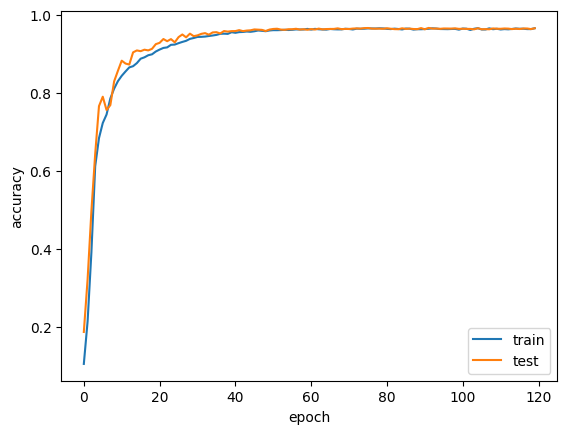

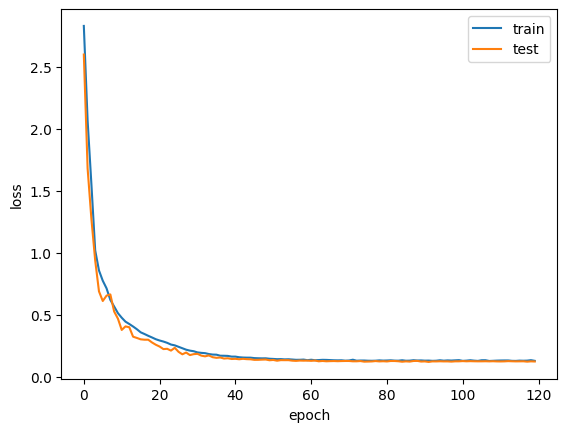

In [15]:
plt.plot(train_accuracy_h, label='train')
plt.plot(test_accuracy_h, label='test')
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend()
plt.show()

plt.plot(train_loss_h, label='train')
plt.plot(test_loss_h, label='test')
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend()
plt.show()

In [16]:
import pandas as pd
dict = {'train_acc': train_accuracy_h, 'test_acc': test_accuracy_h, 'train_loss': train_loss_h, 'test_loss' : test_loss_h}
df = pd.DataFrame(dict)
df.to_csv('logs/best_resnet50_MINST-DVS_Hardtanh_ReLUmaxpool_128x128_FC2_128x128_pretrained_aug_corrected_trilinear.csv')

In [17]:
df.head()

,train_acc,test_acc,train_loss,test_loss
0,0.105143,0.187000,2.828554,2.598013
1,0.214524,0.322444,2.065181,1.679597
2,0.390762,0.496778,1.552804,1.272627
3,0.611238,0.642889,1.019767,0.938144
4,0.683524,0.765444,0.857611,0.689055
